# Build Factor

In this notebook, we will build the factor for each stocks using XGboost model.

In [24]:
from numpy import loadtxt
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from sklearn.metrics import mean_squared_error
import pickle
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import warnings
import matplotlib.pyplot as plt
import statistics as stat
import seaborn as sns
warnings.filterwarnings("ignore")

## Standardize the Factor on Market value and Industries using regression.

In [25]:
filenames=os.listdir(r'data\individual_stocks')
stock_list = []
Ind_list = []
for file in tqdm(filenames):
    if file != "20181217-20190616.xlsx":
        data = pd.read_excel(f"data//individual_stocks//{file}" , sheet_name="Sheet1")
        stock_list += data["代码"].tolist()
        Ind_list += data["中信一级行业"].tolist()

100%|██████████| 16/16 [00:00<00:00, 42.95it/s]


In [26]:
industry_information = pd.DataFrame(columns=["code", "Industry"])
industry_information["code"] = stock_list
industry_information["Industry"] = Ind_list
industry_information.drop_duplicates(inplace=True)

### ADD Industry infromation into featured data.

In [27]:
from statsmodels.formula.api import ols
for clusters in tqdm(range(5)):
    cluster_stocks = loadtxt(f'TrainingData/stocktype{clusters}.txt')
    R2 = []
    AR2 = []
    stock_datac = pd.DataFrame()
    for stock in cluster_stocks.tolist():
        stock = int(stock)
        stock_data = pd.read_csv(f"featured_stock/{stock}.csv")
        index = industry_information.code[industry_information.code == str(stock)+".SH"].index.tolist()
        stock_data["Industry"] = [industry_information["Industry"].loc[index[0]]]*len(stock_data)
        x = stock_data.drop(["time", "code", "Target", "Industry"], axis=1)
        # calculate unstandardized factor
        loaded_model = pickle.load(open(f'model_xgb_cluster{clusters}', 'rb'))
        y_pred = loaded_model.predict(x)
        stock_data["factor_ori"] = y_pred
        # aggregate data into cluster
        stock_datac = pd.concat([stock_datac, stock_data[:1497]], axis=0)
        stock_data.to_csv(f"data_with_factor/{stock}.csv", index=False)
        # train the regression model
    fit = ols('factor_ori ~ C(Industry) + market_value', data=stock_datac).fit()
    R2.append(fit.rsquared)
    AR2.append(fit.rsquared_adj)
    print(f"Average R^2 for cluster {clusters} is {np.mean(R2)}")
    print(f"Average Adjusted R^2 for cluster {clusters} is {np.mean(AR2)}")
    
    for stock in cluster_stocks.tolist():
        stock = int(stock)
        data = pd.read_csv(f"data_with_factor/{int(stock)}.csv")
        data["FACTOR"] = data["factor_ori"] - fit.predict(data)
        data.to_csv(f"data_with_factor/{stock}.csv", index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

Average R^2 for cluster 0 is 0.041118943998806445
Average Adjusted R^2 for cluster 0 is 0.040989207690323104


 20%|██        | 1/5 [00:02<00:09,  2.32s/it]

Average R^2 for cluster 1 is 0.005937502149992002
Average Adjusted R^2 for cluster 1 is 0.005500602813130473


 40%|████      | 2/5 [00:06<00:11,  3.67s/it]

Average R^2 for cluster 2 is 0.016052305890494334
Average Adjusted R^2 for cluster 2 is 0.015684081679921302


 60%|██████    | 3/5 [00:11<00:07,  3.89s/it]

Average R^2 for cluster 3 is 0.023210343599581185
Average Adjusted R^2 for cluster 3 is 0.022690498119857794


 80%|████████  | 4/5 [00:12<00:02,  2.78s/it]

Average R^2 for cluster 4 is 0.0055889721298154615
Average Adjusted R^2 for cluster 4 is 0.005368566292370147


100%|██████████| 5/5 [00:17<00:00,  3.51s/it]


## Factor Analysis

### calculate IC

In [28]:
files=os.listdir(r'data_with_factor')
drop_files = []
for f in files:
    data = pd.read_csv(f'data_with_factor/{f}')
    if len(data) < 1749:
        drop_files.append(f)
len(drop_files)

24

In [29]:
IC_list = []
for i in tqdm(range(1497)):
    # here all data has length 1749, and test data start from 1497
    factor_list = []
    return_list = []
    for f in files:
        if f not in drop_files:
            data_c = pd.read_csv(f'data_with_factor/{f}')
            factor_list.append(data_c["FACTOR"].iloc[i])
            return_list.append(data_c["Target"].iloc[i])
    IC_i = np.corrcoef(factor_list, return_list)
    IC_list.append(IC_i[0][1])

100%|██████████| 1497/1497 [20:39<00:00,  1.21it/s]


In [7]:
IR = stat.mean(IC_list)/stat.stdev(IC_list)
print(f"Our factor's IR is {IR}")
print(f"Our factor's mean IC is {stat.mean(IC_list)}")

Our factor's IR is 1.2002629150610469
Our factor's mean IC is 0.2832708062749759


positive proporation of IC is 0.8904475617902472


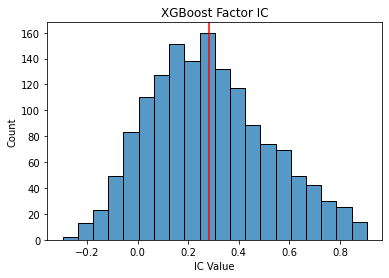

In [30]:
sns.histplot(IC_list, bins=20)
plt.xlabel("IC Value")
plt.axvline(x=stat.mean(IC_list),color='red')
plt.title("XGBoost Factor IC")
plt.savefig("ICdistributionxg")
count = 0 
for ic in IC_list:
    if ic > 0:
        count += 1
print(f"positive proporation of IC is {count/len(IC_list)}")

So, our factor meanly has a relatively steady power on selecting the stocks that are going to rise.

## BACKTESTING

Our backtesting period is 2021-03-01 to 2022-03-02. Index is 1497 to 1742.

In this period, we experienced 3 time index compnents adjustment

Our start moeny is 1000,000. Transection Cost is ignored.

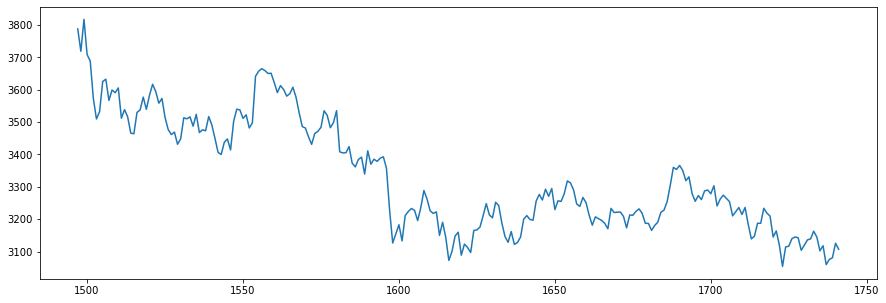

In [9]:
Index = pd.read_excel("data/index.xlsx")
Index.columns = ["Time", "prior_close", "open", "high", "low", "close", "volume", 
                 "amount", "change", "change_percent"]
plt.figure(figsize=(15,5))
plt.plot(Index["close"].iloc[1497:1742])
plt.show()

In [10]:
# period 2021-03-01 ~ 2021-06-14, index 1497:1568
stock_list1 = pd.read_excel("data//individual_stocks//20201214-20210614.xlsx",sheet_name="Sheet1")["代码"].tolist()
# period 2021-06-16 ~ 2021-12-12, index 1568:1690
stock_list2 = pd.read_excel("data//individual_stocks//20210616-20211212.xlsx",sheet_name="Sheet1")["代码"].tolist()
# period 2021-12-13 ~ 2022-03-02, index 1690:1742
stock_list3 = pd.read_excel("data//individual_stocks//20211213-.xlsx",sheet_name="Sheet1")["代码"].tolist()

In [11]:
def order_dict(dicts, n):
    result = []
    result1 = []
    p = sorted([(k, v) for k, v in dicts.items()], reverse=True)
    s = set()
    for i in p:
        s.add(i[1])
    for i in sorted(s, reverse=True)[:n]:
        for j in p:
            if j[1] == i:
                result.append(j)
    for r in result:
        result1.append(r[0])
    return result1

Back_testing in period 2021-03-01 ~ 2021-06-14

In [12]:
def backtesting(stock_list, start, end, startmoney, n):
    # get adjustment dates, 5 days per adjust
    money_list = []
    dates = []
    for i in range((end-start)//5):
        dates.append(start+5*i)
    # get selected stocks at adjustment dates
    for date in tqdm(dates):
        if date != dates[-1]:
            factor_dict = {}
            for stock in stock_list:
                data = pd.read_csv(f"data_with_factor/{stock[:6]}.csv")
                if len(data) == 1749:
                    factor_dict[stock] = data["FACTOR"].iloc[date]
                    
            stock_selected = order_dict(factor_dict, n)#
            print(stock_selected)#
            # get return of selected stocks
            return_list=[]
            for ss in stock_selected:
                r_l = []
                ssdata = pd.read_csv(f"data_with_factor/{ss[:6]}.csv")
                for k in range(5):
                    r_l.append(ssdata["change_rate"].iloc[date+k])
                return_list.append(r_l)
            # calculate the total return
            total_return = []
            for j in range(5):
                return_ = 0
                for h in range(n):#
                    return_ += return_list[h][j]/100
                total_return.append(return_)
            for ret in total_return:
                startmoney = startmoney/n * (n+ret)#
                money_list.append(startmoney)
        # calculaate the finishing dates
        elif date == dates[-1]:
            factor_dict = {}
            for stock in stock_list:
                data = pd.read_csv(f"data_with_factor/{stock[:6]}.csv")
                if len(data) == 1749:
                    factor_dict[stock] = data["FACTOR"].iloc[date]
            stock_selected = order_dict(factor_dict, n)#
            # get return of selected stocks
            return_list=[]
            for ss in stock_selected:
                r_l = []
                ssdata = pd.read_csv(f"data_with_factor/{ss[:6]}.csv")
                for k in range(5+(end-start)%5):
                    r_l.append(ssdata["change_rate"].iloc[date+k])
                return_list.append(r_l)
            # calculate the total return
            total_return = []
            for j in range(5+(end-start)%5):
                return_ = 0
                for h in range(n):#
                    return_ += return_list[h][j]/100
                total_return.append(return_)
            for ret in total_return:
                startmoney = startmoney/n * (n+ret)#
                money_list.append(startmoney)
    return money_list

In [13]:
value1 = backtesting(stock_list1, 1497, 1568, 1000000, 5)

  7%|▋         | 1/14 [00:00<00:06,  1.94it/s]

['600519.SH', '601888.SH', '603288.SH', '600547.SH', '600837.SH']


 14%|█▍        | 2/14 [00:01<00:06,  1.98it/s]

['601888.SH', '600309.SH', '603288.SH', '601012.SH', '600519.SH']


 21%|██▏       | 3/14 [00:01<00:05,  1.97it/s]

['603288.SH', '600276.SH', '600519.SH', '600703.SH', '600030.SH']


 29%|██▊       | 4/14 [00:02<00:05,  1.98it/s]

['600519.SH', '600703.SH', '600030.SH', '600570.SH', '600276.SH']


 36%|███▌      | 5/14 [00:02<00:04,  1.98it/s]

['600745.SH', '600570.SH', '600030.SH', '601688.SH', '601318.SH']


 43%|████▎     | 6/14 [00:03<00:04,  1.95it/s]

['600309.SH', '600030.SH', '600745.SH', '600703.SH', '601688.SH']


 50%|█████     | 7/14 [00:03<00:03,  1.95it/s]

['600519.SH', '601888.SH', '600030.SH', '600745.SH', '601601.SH']


 57%|█████▋    | 8/14 [00:04<00:03,  1.94it/s]

['600519.SH', '600276.SH', '600030.SH', '600745.SH', '603288.SH']


 64%|██████▍   | 9/14 [00:04<00:02,  1.96it/s]

['600519.SH', '600030.SH', '600703.SH', '603288.SH', '600276.SH']


 71%|███████▏  | 10/14 [00:05<00:02,  1.92it/s]

['600519.SH', '600009.SH', '600030.SH', '600276.SH', '600745.SH']


 79%|███████▊  | 11/14 [00:05<00:01,  1.93it/s]

['600030.SH', '600745.SH', '600519.SH', '600837.SH', '600196.SH']


 86%|████████▌ | 12/14 [00:06<00:01,  1.97it/s]

['603288.SH', '600519.SH', '601888.SH', '600031.SH', '600745.SH']


 93%|█████████▎| 13/14 [00:06<00:00,  1.95it/s]

['600519.SH', '600745.SH', '603288.SH', '600031.SH', '601888.SH']


100%|██████████| 14/14 [00:07<00:00,  1.96it/s]


In [14]:
value2 = backtesting(stock_list2, 1568, 1690, value1[-1], 5)

  4%|▍         | 1/24 [00:00<00:11,  2.02it/s]

['600519.SH', '600276.SH', '600104.SH', '600745.SH', '603288.SH']


  8%|▊         | 2/24 [00:00<00:10,  2.02it/s]

['600519.SH', '601899.SH', '600745.SH', '601888.SH', '600585.SH']


 12%|█▎        | 3/24 [00:01<00:10,  1.95it/s]

['600519.SH', '600893.SH', '600276.SH', '600745.SH', '600031.SH']


 17%|█▋        | 4/24 [00:02<00:10,  1.93it/s]

['600519.SH', '600809.SH', '601012.SH', '603288.SH', '600030.SH']


 21%|██        | 5/24 [00:02<00:09,  1.95it/s]

['600519.SH', '600016.SH', '600745.SH', '600030.SH', '601668.SH']


 25%|██▌       | 6/24 [00:03<00:09,  1.98it/s]

['600519.SH', '600030.SH', '600745.SH', '601688.SH', '601628.SH']


 29%|██▉       | 7/24 [00:03<00:08,  1.99it/s]

['600196.SH', '600048.SH', '600009.SH', '601888.SH', '600519.SH']


 33%|███▎      | 8/24 [00:04<00:08,  1.99it/s]

['600519.SH', '600570.SH', '600809.SH', '600009.SH', '601899.SH']


 38%|███▊      | 9/24 [00:04<00:07,  2.00it/s]

['600196.SH', '601899.SH', '600030.SH', '600745.SH', '600309.SH']


 42%|████▏     | 10/24 [00:05<00:06,  2.01it/s]

['600519.SH', '600570.SH', '600745.SH', '600030.SH', '600309.SH']


 46%|████▌     | 11/24 [00:05<00:06,  2.01it/s]

['600809.SH', '600276.SH', '601688.SH', '600837.SH', '600309.SH']


 50%|█████     | 12/24 [00:06<00:05,  2.01it/s]

['601688.SH', '600276.SH', '600837.SH', '601888.SH', '600030.SH']


 54%|█████▍    | 13/24 [00:06<00:05,  2.00it/s]

['603288.SH', '601688.SH', '600837.SH', '600030.SH', '600009.SH']


 58%|█████▊    | 14/24 [00:07<00:04,  2.01it/s]

['603288.SH', '600690.SH', '600030.SH', '600570.SH', '600547.SH']


 62%|██████▎   | 15/24 [00:07<00:04,  2.00it/s]

['600745.SH', '600690.SH', '600309.SH', '600837.SH', '601888.SH']


 67%|██████▋   | 16/24 [00:08<00:03,  2.00it/s]

['600196.SH', '600031.SH', '601899.SH', '600809.SH', '600585.SH']


 71%|███████   | 17/24 [00:08<00:03,  2.00it/s]

['600438.SH', '601888.SH', '600745.SH', '600893.SH', '600031.SH']


 75%|███████▌  | 18/24 [00:09<00:02,  2.01it/s]

['600809.SH', '600031.SH', '600745.SH', '600030.SH', '603288.SH']


 79%|███████▉  | 19/24 [00:09<00:02,  2.01it/s]

['600745.SH', '600519.SH', '600030.SH', '603288.SH', '600309.SH']


 83%|████████▎ | 20/24 [00:10<00:01,  2.01it/s]

['603288.SH', '600031.SH', '600519.SH', '600745.SH', '601899.SH']


 88%|████████▊ | 21/24 [00:10<00:01,  2.01it/s]

['600893.SH', '600519.SH', '601899.SH', '601888.SH', '600030.SH']


 92%|█████████▏| 22/24 [00:11<00:00,  2.01it/s]

['600893.SH', '600031.SH', '601888.SH', '600519.SH', '601899.SH']


 96%|█████████▌| 23/24 [00:11<00:00,  2.01it/s]

['600519.SH', '600745.SH', '601888.SH', '601899.SH', '600030.SH']


100%|██████████| 24/24 [00:11<00:00,  2.00it/s]


In [15]:
value3 = backtesting(stock_list3, 1690, 1742, value2[-1], 5)

 10%|█         | 1/10 [00:00<00:04,  2.01it/s]

['600030.SH', '600745.SH', '601899.SH', '601688.SH', '601633.SH']


 20%|██        | 2/10 [00:00<00:03,  2.02it/s]

['601899.SH', '600519.SH', '600745.SH', '600030.SH', '601633.SH']


 30%|███       | 3/10 [00:01<00:03,  2.02it/s]

['600745.SH', '600519.SH', '600438.SH', '600050.SH', '600030.SH']


 40%|████      | 4/10 [00:01<00:02,  2.01it/s]

['600050.SH', '600519.SH', '600745.SH', '600031.SH', '600030.SH']


 50%|█████     | 5/10 [00:02<00:02,  2.01it/s]

['600050.SH', '600519.SH', '600745.SH', '600809.SH', '600030.SH']


 60%|██████    | 6/10 [00:02<00:01,  2.01it/s]

['600519.SH', '601888.SH', '600809.SH', '600030.SH', '601899.SH']


 70%|███████   | 7/10 [00:03<00:01,  2.01it/s]

['600809.SH', '601899.SH', '600519.SH', '600309.SH', '600893.SH']


 80%|████████  | 8/10 [00:03<00:00,  2.00it/s]

['600519.SH', '600809.SH', '600030.SH', '600031.SH', '601919.SH']


 90%|█████████ | 9/10 [00:04<00:00,  1.99it/s]

['600030.SH', '600893.SH', '600519.SH', '601899.SH', '600900.SH']


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


In [16]:
value1.extend(value2)
value1.extend(value3)

In [17]:
value = [1000000]
value.extend(value1)

In [18]:
coe = 1000000/Index["open"].iloc[1497]
Index["close"] = Index["close"]*coe

In [19]:
Index_list = Index["close"].iloc[1497:1742].values.tolist()

In [20]:
Index_value = [1000000]
Index_value.extend(Index_list)

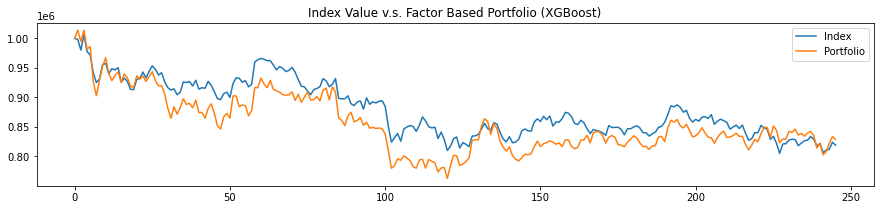

In [21]:
plt.figure(figsize=(15,3))
plt.plot(Index_value, label="Index")
plt.plot(value, label="Portfolio")
plt.legend()
plt.title("Index Value v.s. Factor Based Portfolio (XGBoost)")
plt.savefig("backtestresultxg")

In [22]:
print(f"The yearly return of SSE 50 Index is {(Index_value[-1]-Index_value[0])/Index_value[0]}")
print(f"The yearly return of our factor based portfolio is {(value[-1]-value[0])/value[0]}")
print(f"The excess return of our factor based portfolio is {(value[-1]-value[0])/value[0] - (Index_value[-1]-Index_value[0])/Index_value[0]}")

The yearly return of SSE 50 Index is -0.18087610752444389
The yearly return of our factor based portfolio is -0.1710886776270595
The excess return of our factor based portfolio is 0.009787429897384375


In [23]:
value=np.array(value)
np.save("valuexg.npy",value)